## Import Libraries

In [2]:
import neurokit2 as nk
import h5py
import numpy as np

In [31]:
with h5py.File('ecg_tracings.hdf5', "r") as f:
    print("Keys: %s" % f.keys())
    print(f['tracings'])
    data = np.array(f['tracings'])
    x = np.array(f['tracings'])
    print(f['tracings'])
sampling_rate = 400 

Keys: <KeysViewHDF5 ['tracings']>
<HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">
<HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">


## Cleaning the Noise in the Ecg Data

In [71]:
# Preprocess the ECG signal

ecg_cleaned = nk.ecg_clean(data[11][:,2], sampling_rate=sampling_rate,method="engzeemod2012") 

In [73]:
# Getting ECG R-peaks locations

_, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)

In [64]:
# Heart Rate

hr = 60 * (sampling_rate / np.diff(rpeaks['ECG_R_Peaks']))
hr_mean = np.mean(hr)
hr_std = np.std(hr)

In [99]:
# Rhythm/Heart Rate Variability

hrv = nk.hrv_time(rpeaks, sampling_rate=sampling_rate, show=False)
hrv_mean = hrv['HRV_MeanNN']
hrv_sdnn = hrv['HRV_SDNN']
hrv.keys()

Index(['HRV_MeanNN', 'HRV_SDNN', 'HRV_SDANN1', 'HRV_SDNNI1', 'HRV_SDANN2',
       'HRV_SDNNI2', 'HRV_SDANN5', 'HRV_SDNNI5', 'HRV_RMSSD', 'HRV_SDSD',
       'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN',
       'HRV_IQRNN', 'HRV_SDRMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN'],
      dtype='object')

In [66]:
# ECG Plot (Axis)

def calculate_qrs_amplitudes(ecg_data):
    qrs_amplitudes = np.zeros(ecg_data.shape[1])

    for lead_index in range(ecg_data.shape[1]):
        qrs_amplitudes[lead_index] = np.max(ecg_data[:, lead_index]) - np.min(ecg_data[:, lead_index])

    return qrs_amplitudes
# ecg_data_filtered = nk.ecg_baseline_correct(ecg_cleaned, sampling_rate=sampling_rate)
qrs_amplitudes = calculate_qrs_amplitudes(data)  # Assuming preprocessed data
max_amplitude_lead = np.argmax(qrs_amplitudes)
min_amplitude_lead = np.argmin(qrs_amplitudes)

In [67]:
ecg_cleaned

array([-0.86138682, -0.84075409, -0.84411819, ..., -0.75303777,
       -0.75432431, -0.74949045])

Average PR Interval:  0.19954545454545453


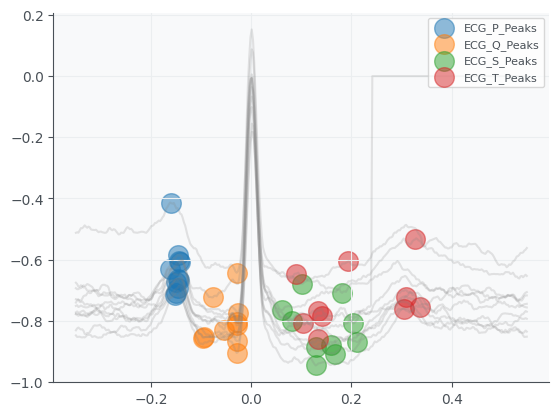

In [74]:
# P-wave and PR interval

_, waves = nk.ecg_delineate(ecg_cleaned, sampling_rate=sampling_rate, show=True)
# Ensure you have corresponding onsets and peaks
if len(waves['ECG_P_Onsets']) > 0 and len(rpeaks['ECG_R_Peaks']) > 0:
    pr_intervals = []
    for p_onset, r_peak in zip(waves['ECG_P_Onsets'], rpeaks['ECG_R_Peaks']):
        pr_intervals.append(r_peak - p_onset)

    # If you need a single average PR interval across the ECG signal:
    average_pr_interval = np.mean(pr_intervals) / sampling_rate  # Convert to seconds 
else:
    # Handle the case where no P-waves or R-peaks were detected
    average_pr_interval = 0
print("Average PR Interval: ", average_pr_interval)


In [82]:
print(waves['ECG_Q_Peaks'])
waves['ECG_R_Offsets']

[368, 706, 1089, 1421, 1805, 2183, 2547, 2891, 3216, 3599, nan]


[394, 758, 1119, 1480, 1829, 2209, 2576, 2916, 3267, 3634, nan]

In [87]:
# Extract QRS complex onsets and offsets

qrs_onsets = np.array(waves['ECG_Q_Peaks'])
qrs_offsets = np.array(waves['ECG_R_Offsets'])  # Note: R-peak is often within the QRS complex

# Calculate duration (in samples)
qrs_durations = qrs_offsets - qrs_onsets
# Convert durations from samples to seconds 
qrs_durations_seconds = qrs_durations / sampling_rate
qrs_durations_seconds = qrs_durations_seconds[~np.isnan(qrs_durations_seconds)]
average_qrs_duration_ms = np.mean(qrs_durations_seconds)

print(f"Average QRS Duration: {average_qrs_duration_ms:.2f} ms")

Average QRS Duration: 89.25 ms


In [91]:
print(waves.keys())

dict_keys(['ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks', 'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks', 'ECG_T_Onsets', 'ECG_T_Offsets'])


In [96]:
# calculate QT interval

p_offsets = np.array(waves['ECG_P_Offsets'])
t_offsets = np.array(waves['ECG_T_Offsets'])

qt_intervals = (t_offsets - p_offsets)
qt_intervals = qt_intervals[~np.isnan(qt_intervals)]
qt_intervals = np.mean(qt_intervals)
qt_intervals


136.2

## Importing Libraries

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
import neurokit2 as nk
import h5py

/Users/tirthpatel/Downloads/Dataset/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [46]:
# Load the ECG data

with h5py.File('ecg_tracings.hdf5', "r") as f:
    print(f['tracings'])
    data = np.array(f['tracings'])
    x = np.array(f['tracings'])
    print(f['tracings'])
sampling_rate = 400 

<HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">
<HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">


In [53]:
# Preprocess the ECG signal


dataframe = defaultdict(list)
row = 0
# Loop through each patient
for paitent in data:
    print(row)
    row += 1
    for i in range(paitent.shape[1]):
        try:
            ecg_cleaned = nk.ecg_clean(paitent[:,i], sampling_rate=sampling_rate,method="engzeemod2012", show=False) 
            _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, show=False)
            _, waves = nk.ecg_delineate(ecg_cleaned, sampling_rate=sampling_rate, show=False)
            # Heart Rate
            hr = 60 * (sampling_rate / np.diff(rpeaks['ECG_R_Peaks']))
            hr_mean = np.mean(hr)
            hr_std = np.std(hr)
        except:
            hr_mean = 0
            hr_std = 0

        try:
            # Rhythm/Heart Rate Variability
            hrv = nk.hrv_time(rpeaks, sampling_rate=sampling_rate, show=False)
            hrv_mean = hrv['HRV_MeanNN']
            hrv_sdnn = hrv['HRV_SDNN']
            
            # ECG Plot (Axis)
            if len(waves['ECG_P_Onsets']) > 0 and len(rpeaks['ECG_R_Peaks']) > 0:
                pr_intervals = []
                for p_onset, r_peak in zip(waves['ECG_P_Onsets'], rpeaks['ECG_R_Peaks']):
                    pr_intervals.append(r_peak - p_onset)

                average_pr_interval = np.mean(pr_intervals) / sampling_rate
            else:
                average_pr_interval = 0

        except:
            average_pr_interval = 0

        # Extract QRS complex onsets and offsets
        # Calculate duration (in samples)
        # Convert durations from samples to seconds
        # Calculate QT interval
        # Ensure you have corresponding onsets and peaks
        # If you need a single average PR interval across the ECG signal:
        try:
            qrs_onsets = np.array(waves['ECG_Q_Peaks'])
            qrs_offsets = np.array(waves['ECG_R_Offsets'])
            qrs_durations = qrs_offsets - qrs_onsets
            qrs_durations_seconds = qrs_durations / sampling_rate
            qrs_durations_seconds = qrs_durations_seconds[~np.isnan(qrs_durations_seconds)]
            average_qrs_duration_ms = np.mean(qrs_durations_seconds)
        except:
            average_qrs_duration_ms = 0

        try:
            p_offsets = np.array(waves['ECG_P_Offsets'])
            t_offsets = np.array(waves['ECG_T_Offsets'])

            qt_intervals = (t_offsets - p_offsets)
            qt_intervals = qt_intervals[~np.isnan(qt_intervals)]
            qt_intervals = np.mean(qt_intervals)
        except:
            qt_intervals = 0
        dataframe[f'lead_{i}_'+'hr_mean'].append(hr_mean)
        dataframe[f'lead_{i}_'+'hr_std'].append(hr_std)
        dataframe[f'lead_{i}_'+'hrv_mean'].append(hrv_mean[0])
        dataframe[f'lead_{i}_'+'hrv_sdnn'].append(hrv_sdnn[0])
        dataframe[f'lead_{i}_'+'average_pr_interval'].append(average_pr_interval)
        dataframe[f'lead_{i}_'+'average_qrs_duration_ms'].append(average_qrs_duration_ms)
        dataframe[f'lead_{i}_'+'qt_intervals'].append(qt_intervals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [55]:
# Convert the dictionary to a pandas DataFrame

import csv
arr = []
for i in dataframe:
    arr.append(len(dataframe[i]))
print(arr)
def dict_to_excel(data, filename):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(data.keys())  # Write the headers
        writer.writerows(zip(*data.values()))  # Write the values
output_file = 'output.csv'
# Convert dictionary to Excel
dict_to_excel(dataframe, output_file)

[827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827, 827]


In [3]:
# Read the data back in
df = pd.read_csv('output.csv')

In [4]:
# Check for missing values
df.isnull().sum()[df.isnull().sum() != 0]

lead_0_average_pr_interval          85
lead_0_average_qrs_duration_ms       6
lead_0_qt_intervals                  4
lead_1_hrv_sdnn                      1
lead_1_average_pr_interval          94
lead_2_hrv_sdnn                      1
lead_2_average_pr_interval          91
lead_2_average_qrs_duration_ms       3
lead_2_qt_intervals                  1
lead_3_hrv_sdnn                      1
lead_3_average_pr_interval          99
lead_3_average_qrs_duration_ms       4
lead_3_qt_intervals                  4
lead_4_hrv_sdnn                      2
lead_4_average_pr_interval          97
lead_5_hrv_sdnn                      1
lead_5_average_pr_interval         114
lead_5_average_qrs_duration_ms      28
lead_5_qt_intervals                 19
lead_6_hrv_sdnn                      1
lead_6_average_pr_interval          94
lead_6_average_qrs_duration_ms       7
lead_6_qt_intervals                  4
lead_7_hrv_sdnn                      1
lead_7_average_pr_interval         101
lead_7_average_qrs_durati

In [5]:
# Fill missing values with the mean
df = df.fillna(df.mean())

In [6]:
# Check for missing values
df.isnull().sum()[df.isnull().sum() != 0]

Series([], dtype: int64)

In [7]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,lead_0_hr_mean,lead_0_hr_std,lead_0_hrv_mean,lead_0_hrv_sdnn,lead_0_average_pr_interval,lead_0_average_qrs_duration_ms,lead_0_qt_intervals,lead_1_hr_mean,lead_1_hr_std,lead_1_hrv_mean,...,lead_10_average_pr_interval,lead_10_average_qrs_duration_ms,lead_10_qt_intervals,lead_11_hr_mean,lead_11_hr_std,lead_11_hrv_mean,lead_11_hrv_sdnn,lead_11_average_pr_interval,lead_11_average_qrs_duration_ms,lead_11_qt_intervals
0,0.453776,0.101271,0.323803,0.048119,0.014402,0.100626,0.521984,0.458912,0.159197,0.269422,...,0.019741,0.115942,0.532220,0.454245,0.106731,0.110911,0.010663,0.037445,0.122776,0.561921
1,0.613924,0.026047,0.164836,0.006430,0.013489,0.577685,0.480827,0.607562,0.215905,0.147172,...,0.016691,0.133333,0.533623,0.603709,0.105115,0.059699,0.007774,0.034454,0.296668,0.413648
2,0.604972,0.014130,0.171310,0.003099,0.003070,0.169760,0.182941,0.604816,0.016445,0.144445,...,0.011817,0.135705,0.357163,0.627330,0.208286,0.054688,0.009230,0.016803,0.158848,0.208509
3,0.535945,0.489610,0.259101,0.114448,0.011242,0.216371,0.505176,0.534226,0.538266,0.219034,...,0.018282,0.159420,0.479596,0.534589,0.487052,0.088994,0.024456,0.033461,0.159253,0.502612
4,0.607284,0.017550,0.169618,0.004118,0.012814,0.108446,0.474940,0.606897,0.020015,0.143160,...,0.019596,0.102174,0.514032,0.607048,0.017398,0.058233,0.000835,0.035338,0.106050,0.536800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,0.472731,0.008551,0.296738,0.003134,0.009109,0.111575,0.185243,0.472609,0.011077,0.250318,...,0.023726,0.209110,0.567870,0.472906,0.009356,0.101701,0.000718,0.028874,0.217082,0.578770
823,0.542563,0.054876,0.223449,0.018845,0.013073,0.440523,0.487858,0.542217,0.061766,0.188613,...,0.019339,0.328317,0.500599,0.542416,0.055742,0.076682,0.004028,0.034454,0.333151,0.526297
824,0.500322,0.029976,0.265304,0.012408,0.004811,0.209941,0.406284,0.499816,0.032571,0.224113,...,0.010999,0.195652,0.507212,0.500141,0.030024,0.091056,0.002622,0.017274,0.138790,0.536085
825,0.520204,0.067903,0.245381,0.026490,0.007431,0.108446,0.415033,0.519851,0.075696,0.207132,...,0.014033,0.106280,0.468103,0.520202,0.069145,0.084159,0.005694,0.024661,0.110320,0.479865


In [8]:
# Read the labels
y = pd.read_csv("./annotations/dnn.csv")
y = y.iloc[:,1:]
y

,1dAVb,RBBB,LBBB,SB,AF,ST
0,0,0,0,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
822,0,0,0,0,0,0
823,0,0,0,0,0,0
824,0,0,0,0,0,0
825,0,0,0,0,0,0


Preprocessing

In [9]:
target_columns = y.columns

In [10]:
merged_df = pd.concat([df, y], axis=1)
merged_df.shape

(827, 90)

In [11]:
merged_df.keys()

Index(['lead_0_hr_mean', 'lead_0_hr_std', 'lead_0_hrv_mean', 'lead_0_hrv_sdnn',
       'lead_0_average_pr_interval', 'lead_0_average_qrs_duration_ms',
       'lead_0_qt_intervals', 'lead_1_hr_mean', 'lead_1_hr_std',
       'lead_1_hrv_mean', 'lead_1_hrv_sdnn', 'lead_1_average_pr_interval',
       'lead_1_average_qrs_duration_ms', 'lead_1_qt_intervals',
       'lead_2_hr_mean', 'lead_2_hr_std', 'lead_2_hrv_mean', 'lead_2_hrv_sdnn',
       'lead_2_average_pr_interval', 'lead_2_average_qrs_duration_ms',
       'lead_2_qt_intervals', 'lead_3_hr_mean', 'lead_3_hr_std',
       'lead_3_hrv_mean', 'lead_3_hrv_sdnn', 'lead_3_average_pr_interval',
       'lead_3_average_qrs_duration_ms', 'lead_3_qt_intervals',
       'lead_4_hr_mean', 'lead_4_hr_std', 'lead_4_hrv_mean', 'lead_4_hrv_sdnn',
       'lead_4_average_pr_interval', 'lead_4_average_qrs_duration_ms',
       'lead_4_qt_intervals', 'lead_5_hr_mean', 'lead_5_hr_std',
       'lead_5_hrv_mean', 'lead_5_hrv_sdnn', 'lead_5_average_pr_interval',

In [12]:
list(target_columns)

['1dAVb', 'RBBB', 'LBBB', 'SB', 'AF', 'ST']

In [13]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_scaled, y, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(661, 84) (166, 84) (661, 6) (166, 6)


In [14]:
# Train a classifier
import pycaret
from pycaret.classification import *


In [24]:
# Initialize the setup
exp0 = setup(data = merged_df, target = '1dAVb', session_id=123, log_experiment=True, experiment_name='ecg',ignore_features=['RBBB', 'LBBB', 'SB', 'AF', 'ST'])

,Description,Value
0,Session id,123
1,Target,1dAVb
2,Target type,Binary
3,Original data shape,"(827, 90)"
4,Transformed data shape,"(827, 85)"
5,Transformed train set shape,"(578, 85)"
6,Transformed test set shape,"(249, 85)"
7,Ignore features,5
8,Numeric features,84
9,Preprocess,True


In [25]:
# Compare all models
best_model0 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9809,0.9318,0.5667,0.7667,0.6267,0.6194,0.6396,0.0600
rf,Random Forest Classifier,0.9706,0.9619,0.2500,0.5000,0.3333,0.3271,0.3479,0.0670
lightgbm,Light Gradient Boosting Machine,0.9688,0.9740,0.4333,0.5000,0.4433,0.4315,0.4433,0.1760
dt,Decision Tree Classifier,0.9654,0.7095,0.4333,0.4750,0.4267,0.4134,0.4272,0.0120
knn,K Neighbors Classifier,0.9637,0.5489,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
qda,Quadratic Discriminant Analysis,0.9637,0.5241,0.0000,0.0000,0.0000,0.0000,0.0000,0.0200
dummy,Dummy Classifier,0.9637,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0080
gbc,Gradient Boosting Classifier,0.9636,0.9548,0.5167,0.4917,0.4700,0.4542,0.4714,0.2310
et,Extra Trees Classifier,0.9619,0.9598,0.0000,0.0000,0.0000,-0.0024,-0.0025,0.0410
svm,SVM - Linear Kernel,0.9602,0.0000,0.0500,0.1000,0.0667,0.0616,0.0657,0.0330


In [26]:
# Assuming df is your DataFrame and target_col is your target column
exp1 = setup(data=merged_df, target='RBBB', session_id=123, transformation=True, fix_imbalance=True, use_gpu=True, log_experiment=True, experiment_name='ecg',ignore_features=['1dAVb', 'LBBB', 'SB', 'AF', 'ST'])

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

,Description,Value
0,Session id,123
1,Target,RBBB
2,Target type,Binary
3,Original data shape,"(827, 90)"
4,Transformed data shape,"(1351, 85)"
5,Transformed train set shape,"(1102, 85)"
6,Transformed test set shape,"(249, 85)"
7,Ignore features,5
8,Numeric features,84
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [27]:
best_model1 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9533,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2700
dummy,Dummy Classifier,0.9533,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1520
et,Extra Trees Classifier,0.9516,0.4084,0.0333,0.1000,0.0500,0.0437,0.0511,0.2470
lightgbm,Light Gradient Boosting Machine,0.9481,0.5523,0.1000,0.2500,0.1400,0.1230,0.1391,0.5120
rf,Random Forest Classifier,0.9447,0.5055,0.0000,0.0000,0.0000,-0.0117,-0.0126,0.3220
gbc,Gradient Boosting Classifier,0.9378,0.4514,0.1167,0.2000,0.1400,0.1128,0.1207,1.8840
ada,Ada Boost Classifier,0.9083,0.4644,0.2500,0.1326,0.1676,0.1242,0.1343,0.5100
dt,Decision Tree Classifier,0.8876,0.5055,0.3333,0.1504,0.2040,0.1520,0.1685,0.2000
lda,Linear Discriminant Analysis,0.8372,0.5018,0.4333,0.1327,0.1991,0.1391,0.1703,0.2330
ridge,Ridge Classifier,0.8199,0.0000,0.6167,0.1528,0.2413,0.1804,0.2391,0.2810


In [28]:

# Assuming df is your DataFrame and target_col is your target column
exp2 = setup(data=merged_df, target='LBBB', session_id=123, transformation=True, fix_imbalance=True, use_gpu=True, log_experiment=True, experiment_name='ecg',ignore_features=['1dAVb', 'RBBB', 'SB', 'AF', 'ST'])
best_model2 = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

,Description,Value
0,Session id,123
1,Target,LBBB
2,Target type,Binary
3,Original data shape,"(827, 90)"
4,Transformed data shape,"(1363, 85)"
5,Transformed train set shape,"(1114, 85)"
6,Transformed test set shape,"(249, 85)"
7,Ignore features,5
8,Numeric features,84
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.9671,0.6899,0.5000,0.4667,0.4667,0.4545,0.4626,0.5330
rf,Random Forest Classifier,0.9654,0.6361,0.2000,0.3000,0.2333,0.2244,0.2320,0.3310
lda,Linear Discriminant Analysis,0.9654,0.5000,0.8167,0.5500,0.6433,0.6268,0.6474,0.2470
qda,Quadratic Discriminant Analysis,0.9637,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2800
dummy,Dummy Classifier,0.9637,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1710
lightgbm,Light Gradient Boosting Machine,0.9620,0.7228,0.2500,0.3500,0.2833,0.2693,0.2773,0.5330
et,Extra Trees Classifier,0.9619,0.8281,0.0500,0.1000,0.0667,0.0608,0.0644,0.2700
gbc,Gradient Boosting Classifier,0.9568,0.8036,0.2500,0.3167,0.2633,0.2450,0.2542,1.9120
ridge,Ridge Classifier,0.9395,0.0000,0.8167,0.3888,0.5089,0.4833,0.5298,0.2480
dt,Decision Tree Classifier,0.9361,0.5009,0.2500,0.2167,0.2300,0.1980,0.1991,0.2180


In [29]:

# Assuming df is your DataFrame and target_col is your target column
exp3 = setup(data=merged_df, target='SB', session_id=123, transformation=True, fix_imbalance=True, use_gpu=True, log_experiment=True, experiment_name='ecg',ignore_features=['1dAVb', 'RBBB', 'LBBB', 'AF', 'ST'])
best_model3 = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

,Description,Value
0,Session id,123
1,Target,SB
2,Target type,Binary
3,Original data shape,"(827, 90)"
4,Transformed data shape,"(1379, 85)"
5,Transformed train set shape,"(1130, 85)"
6,Transformed test set shape,"(249, 85)"
7,Ignore features,5
8,Numeric features,84
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9913,0.4225,0.8500,0.7667,0.7967,0.7932,0.7992,0.3220
et,Extra Trees Classifier,0.9913,0.6539,0.8500,0.7667,0.7967,0.7932,0.7992,0.2740
ada,Ada Boost Classifier,0.9896,0.4008,0.9000,0.7500,0.8000,0.7960,0.8089,0.5960
lightgbm,Light Gradient Boosting Machine,0.9896,0.4767,0.7500,0.6667,0.6967,0.6932,0.6992,0.5450
gbc,Gradient Boosting Classifier,0.9827,0.3115,0.6500,0.6167,0.6133,0.6066,0.6167,1.6770
dt,Decision Tree Classifier,0.9810,0.4489,0.5500,0.4833,0.5067,0.5007,0.5059,0.2130
lda,Linear Discriminant Analysis,0.9776,0.5105,0.8500,0.5333,0.6367,0.6262,0.6538,0.2620
qda,Quadratic Discriminant Analysis,0.9775,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3720
dummy,Dummy Classifier,0.9775,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1780
lr,Logistic Regression,0.9758,0.4956,0.7000,0.4583,0.5333,0.5230,0.5454,1.0560


In [30]:

# Assuming df is your DataFrame and target_col is your target column
exp4 = setup(data=merged_df, target='AF', session_id=123, transformation=True, fix_imbalance=True, use_gpu=True, log_experiment=True, experiment_name='ecg',ignore_features=['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST'])
best_model4 = compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

,Description,Value
0,Session id,123
1,Target,AF
2,Target type,Binary
3,Original data shape,"(827, 90)"
4,Transformed data shape,"(1391, 85)"
5,Transformed train set shape,"(1142, 85)"
6,Transformed test set shape,"(249, 85)"
7,Ignore features,5
8,Numeric features,84
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the prov

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9879,0.2412,0.1000,0.1000,0.1000,nan,0.0982,0.4020
qda,Quadratic Discriminant Analysis,0.9879,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.3090
dummy,Dummy Classifier,0.9879,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.1770
et,Extra Trees Classifier,0.9862,0.4377,0.0000,0.0000,0.0000,nan,-0.0018,0.2680
ada,Ada Boost Classifier,0.9810,0.5158,0.0000,0.0000,0.0000,nan,-0.0060,0.5920
gbc,Gradient Boosting Classifier,0.9810,0.2254,0.1000,0.1000,0.1000,nan,0.0940,1.9920
lightgbm,Light Gradient Boosting Machine,0.9810,0.3570,0.1000,0.1000,0.1000,nan,0.0940,0.5450
dt,Decision Tree Classifier,0.9741,0.3500,0.2000,0.1000,0.1333,nan,0.1305,0.2170
nb,Naive Bayes,0.9308,0.3500,0.4000,0.1333,0.1905,0.1760,0.2066,0.1980
lda,Linear Discriminant Analysis,0.9102,0.3526,0.2000,0.0291,0.0500,0.0308,0.0504,0.2760
